In [1]:
import os
import re
import cv2
import math
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow 
from matplotlib import pyplot as plt

METERS_PER_PIXEL = 156543.03392 * math.cos(54 * math.pi / 180) / math.pow(2, 17)
PRECISION = 1e-5
MASK_COLOR = 255

def get_tile_coord_from_filename(image_path):
    result = re.findall(r'\d+', os.path.basename(image_path))
    return [int(val) for val in result]

def get_mask_info(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    height, width = image.shape[0:2]
    mask_pix_count = np.sum(image == MASK_COLOR)
    mask_pix_percentage = mask_pix_count / (width * height)
    return [mask_pix_count, mask_pix_percentage]

density = {}
    
def process_image(image_path):
    x, y = get_tile_coord_from_filename(image_path)
    mask_pix_count, mask_pix_percentage = get_mask_info(image_path)
    density[(x, y)] = (mask_pix_count, mask_pix_percentage)

def process_dir(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".png"):
                try:
                    process_image(os.path.join(directory, file))
                except:
                    print(os.path.join(directory, file))



In [2]:
def get_min_coord():
    min_x = min([coord[0] for coord in density.keys()])
    min_y = min([coord[1] for coord in density.keys()])
    return (min_x, min_y)

def get_max_coord():
    max_x = max([coord[0] for coord in density.keys()])
    max_y = max([coord[1] for coord in density.keys()])
    return (max_x, max_y)

def get_area():
    area = 0.0
    for x, y in density:
        count, percentage = density[(x, y)]
        area += count * METERS_PER_PIXEL
    return area

def get_total_area():
    total_area = 0.0
    for x, y in density:
        total_area += 256 * 256 * METERS_PER_PIXEL
    return total_area

def get_image():
    min_x, min_y = get_min_coord()
    max_x, max_y = get_max_coord()
    width = max_x + 1 - min_x
    height = max_y + 1 - min_y
    result_info = [[0.0 for i in range(height)] for j in range(width)]
    for x, y in density:
        count, percentage = density[(x, y)]
        result_info[x - min_x][y - min_y] = percentage
    min_percentage = np.min(result_info)
    max_percentage = np.max(result_info)
    image_data = []
    for lst in result_info:
        for value in lst:
            color_val = 0
            if (max_percentage - min_percentage) != 0.0:
                color_val = (value - min_percentage) / (max_percentage - min_percentage) * 255
            image_data.append(int(color_val))
    result_image = Image.frombytes('L', (width, height), bytes(image_data), 'raw')
    imshow(np.asarray(result_image))

    

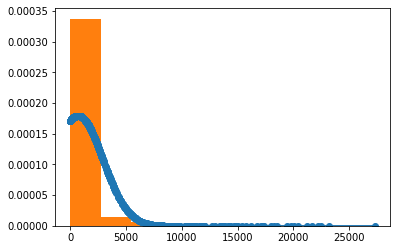

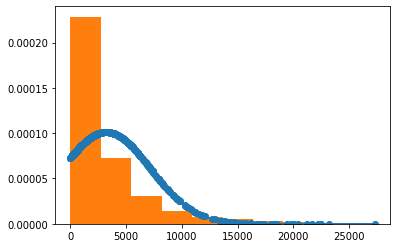

In [9]:
import numpy as np
import scipy.stats as stats
import pylab

areas = sorted([density[info][0] * METERS_PER_PIXEL for info in density])
areas_without_zeros = sorted([density[info][0] * METERS_PER_PIXEL for info in density if density[info][0] > PRECISION])
pdf = stats.norm.pdf(areas, np.mean(areas), np.std(areas))
pylab.plot(areas, pdf,'-o')
pylab.hist(areas, density=True) 
pylab.show(areas, pdf)
pdf = stats.norm.pdf(areas_without_zeros, np.mean(areas_without_zeros), np.std(areas_without_zeros))
pylab.plot(areas_without_zeros, pdf,'-o')
pylab.hist(areas_without_zeros, density=True) 
pylab.show(areas_without_zeros, pdf)

Метров в пикселе: 0.7020087180122099 м/пикс
Средняя площадь зданий на тайл: 670.8647567776541 м^2
Средняя процента зданий на тайл: 0.014581847134493203%
Медианная площадь зданий на тайл: 0.0 м^2
Медианный процент зданий на тайл: 0.0%
Максимальная площадь зданий на тайл: 27314.457209137076 м^2
Максимальный процент зданий на тайл: 0.5937042236328125%
Минимальный площадь зданий на тайл, не равный нулю: 2.1060261540366296 м^2
Минимальный процент зданий на тайл, не равный нулю: 4.57763671875e-05%
Площадь: 2837757.921169476 м^2
Вся площадь: 194608947.34362233 м^2


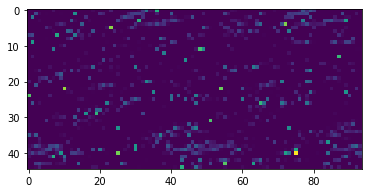

In [5]:
import statistics
process_dir("/home/ave/BigData/out_2/")
print("Метров в пикселе: {} м/пикс".format(METERS_PER_PIXEL))
print("Средняя площадь зданий на тайл: {} м^2".format(statistics.mean([density[info][0] * METERS_PER_PIXEL for info in density])))
print("Средняя процента зданий на тайл: {}%".format(statistics.mean([density[info][1] for info in density])))
print("Медианная площадь зданий на тайл: {} м^2".format(statistics.median([density[info][0] * METERS_PER_PIXEL for info in density])))
print("Медианный процент зданий на тайл: {}%".format(statistics.median([density[info][1] for info in density])))
print("Максимальная площадь зданий на тайл: {} м^2".format(max([density[info][0] * METERS_PER_PIXEL for info in density])))
print("Максимальный процент зданий на тайл: {}%".format(max([density[info][1] for info in density])))
print("Минимальный площадь зданий на тайл, не равный нулю: {} м^2".format(min([density[info][0] * METERS_PER_PIXEL for info in density if density[info][0] > PRECISION])))
print("Минимальный процент зданий на тайл, не равный нулю: {}%".format(min([density[info][1] for info in density if density[info][1] > PRECISION])))

print("Площадь: {} м^2".format(get_area()))
print("Вся площадь: {} м^2".format(get_total_area()))
get_image()